**Import required libraries**

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from random import shuffle
import math
import random
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pickle
from datetime import datetime
import pandas as pd

In [40]:
class Connect2Model(nn.Module):

    def __init__(self, board_size, action_size, device):

        super(Connect2Model, self).__init__()

        self.device = device
        self.size = board_size
        self.action_size = action_size

        self.fc1 = nn.Linear(in_features=self.size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)

        # Two heads on our network
        self.action_head = nn.Linear(in_features=64, out_features=self.action_size)
        self.value_head = nn.Linear(in_features=64, out_features=1)

        self.to(device)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        action_logits = self.action_head(x)
        value_logit = self.value_head(x)

        return F.softmax(action_logits, dim=1), value_logit

    def predict(self, board):
        board = torch.FloatTensor(board.astype(np.float32)).to(self.device)
        board = board.view(1, self.size)
        self.eval()
        with torch.no_grad():
            pi, v = self.forward(board)

        return pi.data.cpu().numpy()[0], v.data.cpu().numpy()[0]

In [41]:
import os
import numpy as np
from random import shuffle

import torch
import torch.optim as optim

class Trainer:

    def __init__(self, dl_model , model, args):
        self.dl_model = dl_model
        self.model = model
        self.args = args
        self.mcts = MCTS_DL(self.dl_model, self.model, self.args)
        self.scores_mcts_dl = np.array([])
        self.scores_greedy = np.array([])
        self.scores_random = np.array([])
        self.scores_mcts = np.array([])

    def exceute_episode(self, tmp, plotting, random, greedy):

        train_examples = []
        state = []

        while True:

            self.mcts = MCTS_DL(self.dl_model, self.model, self.args)
            root = self.mcts.run(state)

            action_probs = [0 for _ in range(self.model.n_songs)]
            for k, v in root.children.items():
                action_probs[k] = v.visit_count

            action_probs = action_probs / np.sum(action_probs)
            train_examples.append((state, action_probs))

            action = root.select_action(temperature=tmp)
            state = self.model.get_next_state(state, action)
            reward = self.model.get_reward(state)

            
            if reward is not None:
                ret = []
                for hist_state, hist_action_probs in train_examples:
                    # [Board, actionProbabilities, Reward]
                    ret.append((self.model.state_to_input(hist_state), hist_action_probs, reward))
                print(hist_state, reward)

                if plotting:

                    self.scores_mcts_dl = np.append(self.scores_mcts_dl, reward)
                    self.scores_greedy = np.append(self.scores_greedy, get_greedy_trajectory(self.model))
                    self.scores_random = np.append(self.scores_random, get_random_trajectory(self.model))
                    self.scores_mcts = np.append(self.scores_mcts, get_MCTS_trajectory(self.model))
                    plt.plot(self.scores_mcts_dl, label='DeepMCTS')
                    plt.plot(self.scores_mcts, label='Vanilla MCTS')
                    plt.plot(self.scores_greedy, label='Greedy policy')
                    plt.plot(self.scores_random, label='Random policy')
                    plt.legend()
                    plt.show()
                    
                return ret

    def learn(self, temperature, random, greedy):
        for i in range(1, self.args['numIters'] + 1):

            print("{}/{}".format(i, self.args['numIters']))

            train_examples = []

            for eps in range(self.args['numEps']):
                iteration_train_examples = self.exceute_episode(temperature, False, random, greedy)
                train_examples.extend(iteration_train_examples)

            self.exceute_episode(0, True, random, greedy)
            shuffle(train_examples)
            self.train(train_examples)
            filename = self.args['checkpoint_path']
            self.save_checkpoint(folder=".", filename=filename)

    def train(self, examples):
        optimizer = optim.Adam(self.dl_model.parameters(), lr=5e-4)
        pi_losses = []
        v_losses = []

        for epoch in range(self.args['epochs']):
          self.dl_model.train()

          batch_idx = 0

          while batch_idx < int(len(examples) / self.args['batch_size']):
            sample_ids = np.random.randint(len(examples), size=self.args['batch_size'])
            boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
            boards = torch.FloatTensor(np.array(boards).astype(np.float64))
            target_pis = torch.FloatTensor(np.array(pis))
            target_vs = torch.FloatTensor(np.array(vs).astype(np.float64))

            # predict
            boards = boards.contiguous().cuda()
            target_pis = target_pis.contiguous().cuda()
            target_vs = target_vs.contiguous().cuda()

            # compute output
            out_pi, out_v = self.dl_model(boards)
            l_pi = self.loss_pi(target_pis, out_pi)
            l_v = self.loss_v(target_vs, out_v)
            total_loss = l_pi + l_v

            pi_losses.append(float(l_pi))
            v_losses.append(float(l_v))

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            batch_idx += 1
    

          print()
          print("Policy Loss", np.mean(pi_losses))
          print("Value Loss", np.mean(v_losses))
          # print("Examples:")
          # print(out_pi[0].detach())
          # print(target_pis[0])
          

    def loss_pi(self, targets, outputs):
        loss = -(targets * torch.log(outputs)).sum(dim=1)
        return loss.mean()

    def loss_v(self, targets, outputs):
        loss = torch.sum((targets-outputs.view(-1))**2)/targets.size()[0]
        return loss

    def save_checkpoint(self, folder, filename):
        if not os.path.exists(folder):
            os.mkdir(folder)

        filepath = os.path.join(folder, filename)
        torch.save({
            'state_dict': self.dl_model.state_dict(),
        }, filepath)

In [42]:
import pandas as pd
import os
import numpy as np
import itertools
import scipy.spatial.distance as distlib
import random as rand

class RecommendationSystem:
    def __init__(self, dataset_with_bins, n_features, n_bins):
        '''
        We assume here that the columns of the dataset here are already the binary percentile bins for all features 
        For sanity check: n_features x n_bins = length(dataset_with_bins)
        '''
        self.data = dataset_with_bins # assuming this is the whole dataset split that we want to work with
        self.data.index = np.arange(np.shape(self.data)[0])
        self.n_features = n_features
        self.n_bins = n_bins
        self.k_t = 10 # for now, just queue the user 10 songs to choose from
        self.k_s = 10
        self.var_param = 100 # parameter that determines the "variance" of the user reference distribution that the user song picks are generated from
        self.initial_songs = self.gen_user_song_picks() # assuming this is still a pandas df of k_s rows, but only containing the song rows that the user prefers
        
        # Initialize preferences
        self.init_song_preferences()
        self.init_transition_preferences()

    def init_song_preferences(self):
        # Initialize preference array
        self.phi_s = (1/((self.k_s + 1) * self.n_bins)) * np.ones((self.n_features * self.n_bins, 1))
        tmp = (np.sum(self.initial_songs.values, axis = 0)) * (1/(self.k_s + 1))
        self.phi_s = self.phi_s + np.reshape(tmp, (len(tmp), 1))

    def theta_t(self, idx_a, idx_b):
        '''
        Input: indices of songs a and b within the provided dataset (int)

        Output: vector theta_t, assuming the feature sequence of 1-i, 1-2, ..., 1-n_bins, 2-1, ..., n_bins-1, n_bins-2, ..., n_bins-n_bins
        '''
        indices = np.array([], dtype=int)
        for i in range(self.n_features):
            a_bin_idx = np.where(self.data.loc[idx_a][self.data.columns[i*self.n_bins:(i+1)*self.n_bins]] == 1.0)[0]
            b_bin_idx = np.where(self.data.loc[idx_b][self.data.columns[i*self.n_bins:(i+1)*self.n_bins]] == 1.0)[0]
            indices = np.append(indices, int(i*(self.n_bins*self.n_bins) + a_bin_idx*self.n_bins + b_bin_idx))
        out = np.zeros((self.n_bins * self.n_bins * self.n_features, 1))
        out[indices] = 1
        return out

    def init_transition_preferences(self):

        # Take the upper-median preference split
        self.Rs = np.sum(np.matmul(self.data.values, self.phi_s), axis=1)
        self.Mstar = self.data.copy()
        self.Mstar['Rs'] = self.Rs
        self.Mstar.sort_values('Rs', inplace = True, ascending = False)
        self.Mstar = self.Mstar[:np.shape(self.Mstar)[0] // 2]
        self.Mstar['old_index'] = self.Mstar.index
        self.Mstar.index = np.arange(np.shape(self.Mstar)[0])

        # Generate 10th percentile distance of all pairwise distances from M (not M*)
        self.diff = distlib.pdist(self.data.values, 'cosine')
        self.delta = np.percentile(self.diff, 10, axis=0)
        self.distances = distlib.squareform(self.diff)
        np.fill_diagonal(self.distances, np.inf)

        # Generate a representative subset of M*
        self.representatives, self.clusters_t = self.delta_medoids(self.Mstar, self.delta, True)
        song_prev = np.random.choice(self.representatives)

        if self.k_t > len(self.representatives):
            print("[WARNING] k_t parameter too large for generated representative subset. Consider using a larger dataset or reducing k_t value")
            print("Setting k_t =", len(self.representatives), "to match the generated number of representatives through delta-medoids")
            self.k_t = len(self.representatives)

        song_prev = np.random.choice(self.representatives)
        self.representatives = np.delete(self.representatives, np.argwhere(self.representatives == song_prev))

        self.phi_t = (1/(self.k_t * self.n_bins*self.n_bins)) * np.ones((self.n_features * self.n_bins * self.n_bins, 1))

        for i in range(self.k_t-1):
            next_song, theta = self.pick_next_song(song_prev, self.user_ref_samples_t[:, i])
            self.phi_t += (1/(self.k_t)) * theta
            song_prev = next_song
 

    def one_shot_delta(self, data, delta, clusters, init):
        # Remember to change the distance metric in case we change delta distance definition
        if init:
            distances = distlib.pdist(data[data.columns[:-2]], 'cosine')
        else:
            distances = distlib.pdist(data, 'cosine') # Same as for delta medoids method
        distances = distlib.squareform(distances)
        representatives_init = np.array(list(clusters.keys()), dtype = 'int32')
        clusters = dict(zip(representatives_init, [np.array([], dtype='int32') for _ in range(len(representatives_init))])) # We want to start with a dictionary with the keys being there, but the elements being empty, as all elements will be reassigned anyways
        for index, row in data.iterrows():
            dist = 1e6
            representatives = np.array(list(clusters.keys()), dtype = 'int32')
            if len(representatives) > 0:
                rep = np.intersect1d(np.where(distances[:, index] == np.min(distances[:, index][representatives]))[0], representatives) # Take the intersection to make sure we select the correct index belonging to the set of representatives
                
                if len(rep) > 1:
                    if index not in rep: # Check if already in rep --> we do not want to add it to another cluster if it is already a representative (in case index and another song have the same feature vectors, miraculously)
                        rep = rep[0]
                    else:
                        rep = index
                else:
                    rep = int(rep)
                dist = distances[rep, index]
            if dist <= delta:
                clusters[rep] = np.append(clusters[rep], index)
            else: 
                clusters[index] = np.array([index])

        dbg = np.sum([len(val) for val in clusters.values()])
        if dbg != np.shape(data)[0]:
            print("WARNING: stuff going wrong here, generated list of cluster elements does not sum up to the total size of the song dataset selected")
        return clusters

    def delta_medoids(self, data, delta, init):
        if init:
            distances = distlib.pdist(data[data.columns[:-2]], 'cosine')
        else:
            distances = distlib.pdist(data, 'cosine') # When we want to use it to generate normal clusters of the whole dataset - we do not have anything appended, so use all columns
        distances = distlib.squareform(distances)
        np.fill_diagonal(distances, 0)
        exit_loop = False
        i = 0
        clusters = {}
        while not exit_loop:
            i +=1
            clusters = self.one_shot_delta(data, delta, clusters, init)
            if 1 != i:
                representatives_prev = representatives
            else:
                representatives_prev = np.array([], dtype = 'int32')
            representatives = np.array([], dtype = 'int32')
            for cluster in clusters.items():
                cluster = cluster[1]
                cluster_dists = distlib.pdist(data.loc[cluster], 'cosine')
                cluster_dists = distlib.squareform(cluster_dists)
                argmin = np.argmin(np.sum(cluster_dists, axis=0))
                representatives = np.append(representatives, cluster[argmin])
            
            if np.array_equal(np.sort(representatives), np.sort(representatives_prev)):
                exit_loop = True

        # Convert back to indices of the original data array
        if init:
            representatives = data['old_index'][np.in1d(data.index, representatives)].values # Do not need to convert back if clustering songs together for action space reduction, as we preserve the old indices anyways
        return representatives, clusters

    def pick_next_song(self, previous_song, reference):
        reference = np.reshape(reference, (len(reference), 1))
        min_dist = 1e06
        for song in self.representatives:
            theta_current = self.theta_t(previous_song, song)
            dist = distlib.cosine(theta_current, reference)
            if dist < min_dist:
                min_theta = theta_current
                min_song = song
                min_dist = dist

        self.representatives = np.delete(self.representatives, np.argwhere(self.representatives == min_song)[0])
        return min_song, min_theta
    
    def gen_user_song_picks(self):
        """
        Returns a subset of the dataframe of k_s songs closest to the random samples generated from the user preference distribution, simulating picked user reference
        The user reference distribution is generated here and can be accessed through self.user_ref
        """
        self.user_ref_s, self.user_ref_samples_s, self.user_ref_t, self.user_ref_samples_t  = self.gen_user_ref()
        sample_index = np.arange(np.shape(self.data)[0], np.shape(self.data)[0] + self.k_s, dtype='int32')
        to_append = pd.DataFrame(np.transpose(self.user_ref_samples_s), index = sample_index)
        sample = self.data.copy().append(to_append)
        dists_with_samples = distlib.pdist(sample, metric='cosine')
        dists_with_samples = distlib.squareform(dists_with_samples)
        np.fill_diagonal(dists_with_samples, np.inf)
        user_selected_songs = np.array([], dtype='int32')

        for i in sample_index:
            min_ind = np.argmin(dists_with_samples[:sample_index[0], i])
            user_selected_songs = np.append(user_selected_songs, min_ind)
            dists_with_samples[min_ind, :] = np.inf #Do not allow to pick this row anymore
        return self.data.loc[user_selected_songs]
        

    def gen_user_ref(self):
        '''
        Generates a random "ground-truth" user song and transitions preference distributions over features (kind of
        like a ground-truth phi_s and phi_t), as well as k_s for songs (and k_t, for transitions, respectively) samples from it, that are later used to 
        simulate user song preferences and transition preferences that the user preference vectors phi_s and phi_t are learned from

        Input: var_param: a parameter that alters the variance of the distribution over each feature of the ground truth user preference vectors, int

        Output: - user_reference_s (numpy array, n_bins x n_features, 1): ground-truth user song preference distribution over each feature
                - user_samples_s (numpy array, n_bins x n_features, k_s): k_s samples of the "ground truth phi_s", used to select initial, user-preferred songs
                - user_reference_t (numpy array, n_bins*n_bins x n_features, 1): ground-truth user transition preference distribution over each feature
                - user_samples_t (numpy array, n_bins*n_bins x n_features, k_t): k_t samples of the "ground truth phi_t", used to select songs that the user preference phi_t will be estimated from 
        '''
    
        user_reference_s = np.array([])
        user_reference_t = np.array([])

        user_samples_s = np.zeros((self.n_features * self.n_bins, self.k_s))
        user_samples_t = np.zeros((self.n_features * self.n_bins * self.n_bins, self.k_t))

        for i in range(self.n_features):
            vec_s = np.random.randint(1, self.var_param, (self.n_bins, ))
            vec_s = vec_s/np.sum(vec_s)
            user_reference_s = np.append(user_reference_s, vec_s)
            sample_bins_s = np.array(rand.choices(np.arange(self.n_bins, dtype='int32'), vec_s, k = self.k_s))
            user_samples_s[i*self.n_bins + sample_bins_s, np.arange(self.k_s, dtype='int32')] = 1
            
            vec_t = np.random.randint(1, self.var_param, (self.n_bins * self.n_bins, ))
            vec_t = vec_t/np.sum(vec_t)
            user_reference_t = np.append(user_reference_t, vec_t)
            sample_bins_t = np.array(rand.choices(np.arange(self.n_bins * self.n_bins, dtype='int32'), vec_t, k = self.k_t))
            user_samples_t[i*self.n_bins*self.n_bins + sample_bins_t, np.arange(self.k_t, dtype='int32')] = 1

        return user_reference_s, user_samples_s, user_reference_t, user_samples_t

In [43]:
def ucb_score(parent, child):
    """
    The score for an action that would transition between the parent and child.
    """
    if child.prior < 0.0001:
      return -100000000
    prior_score = child.prior * math.sqrt(parent.visit_count) / (child.visit_count + 1)
    if child.visit_count > 0:
        # The value of the child is from the perspective of the opposing player
        value_score = child.value()
    else:
        value_score = 100000

    return value_score + prior_score

In [44]:
class MDP:
    def __init__(self, file_name, playlist_length, action_space_size):

        df = pd.read_csv(file_name, index_col=None)

        self.features = ['duration', 'key_confidence', 'end_of_fade_in', 'mode_confidence', 'start_of_fade_out', 'tempo',
                    'artist_hotttnesss', 'song_hotttnesss']

        for feature in self.features:
          filter = df[feature] > 0
          df = df[filter]
        
        self.filtered_df = df[self.features]
        self.filtered_df.dropna(inplace=True)
        self.filtered_df = self.filtered_df.head(action_space_size)
        self.filtered_df = self.filtered_df.reset_index(drop=True)
        self.whole_df = self.filtered_df.copy()

        self.filtered_df = self.filtered_df.head(20) # Reduce the dataset (hence the action space) here 

        self.n_rows = len(self.filtered_df.index)

        self.n_songs = self.n_rows
        self.n_bins = 10
        self.n_features = len(self.features)
        self.id_song_to_vec = dict()
        self.songs = set()        
        self.song_id_to_song_row = []
        self.song_priors = []
        self.playlist_length = playlist_length
        self.id_song_to_features = dict()

        song_id = 0
      
        for song, row in self.filtered_df.iterrows():
            self.id_song_to_vec[song_id] = np.zeros(80)
            self.id_song_to_features[song_id] = np.zeros(self.n_features)

            for f in range(self.n_features):
              feature = self.features[f]
              self.id_song_to_features[song_id][f] = row[feature]

            self.songs.add(song_id)
            self.song_id_to_song_row.append(row)
            self.song_priors.append(1)
            song_id += 1

        self.songs_list = [i for i in range(self.n_songs)]

        for f in range(self.n_features):

            feature = self.features[f]
            sorted_df = self.filtered_df.sort_values(by=[feature])
            i = 0
            for idx, row in sorted_df.iterrows():
                bin = i * self.n_bins // self.n_rows
                self.id_song_to_vec[idx][f * 10 + bin] = 1
                i += 1


        df_input = pd.DataFrame.from_dict(self.id_song_to_vec, orient='index')
        # Select songs that the user prefers (randomly selecting 5 for now, change later)
        self.init_prefs = df_input.loc[rand.sample(self.songs, 5)]


        self.rs = RecommendationSystem(df_input, self.n_features, self.n_bins)
        self.phi_s = self.rs.phi_s.reshape(80)
        self.phi_t = self.rs.phi_t.reshape(800)
        self.delta_action_clustering = self.rs.delta # Try out this delta for now 
        self.representatives_actions, self.clusters_actions = self.rs.delta_medoids(df_input, self.delta_action_clustering, False)

        self.transition_reward = np.zeros((self.n_songs, self.n_songs))
        
        self.song_reward = np.zeros(self.n_songs)
        for i in range(self.n_songs):
          self.song_reward[i] = np.dot(self.phi_s, self.theta_s(i))
          for j in range(self.n_songs):
            self.transition_reward[i,j] = np.dot(self.phi_t, self.get_theta_t(i, j))

    def get_next_state(self, state, action):
      return state + [action]
      
    def get_valid_actions(self, state):
        # All actions are invalid by default
        valid_actions = [0] * self.n_songs

        for song in range(self.n_songs):
            if song not in state:
                valid_actions[song] = 1

        return valid_actions

    def state_to_input(self, state):
      input = np.ones(self.playlist_length*self.n_features*10)*-1
      for i in range(len(state)):
        song = state[i]
        input[i*self.n_features*10:(i+1)*self.n_features*10] = self.id_song_to_vec[song]
      return input

    def get_reward(self, final_state):
      if len(final_state) < self.playlist_length:
        return None
      elif len(final_state) == self.playlist_length:
        state = []
        trajectory_states = [state]
        trajectory_actions = []
        for song in final_state:
          state = self.get_next_state(state, song)
          trajectory_states.append(state)
          trajectory_actions.append(song)
          
        return self.payoff_trajectory(trajectory_states, trajectory_actions)
      else:
        print("Error: length > self.playlist_length")
        return None


    def get_theta_t(self, s1, s2):
        theta_t = np.zeros(800)
        for f in range(len(self.features)):
            for i in range(10):
                for j in range(10):
                    if self.id_song_to_vec[s1][f*10 + i] == 1 and  self.id_song_to_vec[s2][f*10 + j]:
                        theta_t[f*100 + i*10 + j] = 1
        return  theta_t

    def theta_s(self, s):
        return self.id_song_to_vec[s]

    def R(self, s, a):
        Rs = self.song_reward[a]
        Rt = 0
        for i in range(len(s)):
            song_past = s[len(s)-i-1]
            Rt += 1/((i+1)**(0.1)) * self.transition_reward[song_past,a]
        return Rs + Rt


    def payoff_trajectory(self, trajectory_states, trajectory_actions):
      payoff = 0

      for t in range(len(trajectory_actions)):
        payoff +=  self.R(trajectory_states[t], trajectory_actions[t])
      return payoff

    def MC_value(self, s):
      count = 0
      sum_values = 0
      state = s
      # Past episodes
      episode_states = [[]]
      episode_actions = []

      for i in range(model.playlist_length):
        if i < len(s):
          state = s[:i+1]
          action = s[i]
        else:
          action_probs = list(model.song_priors)
          for song_id in range(model.n_songs):
            if song_id in state:
              action_probs[song_id] = 0

          action_probs = np.array(action_probs)/np.sum(np.array(action_probs))
          action = np.random.choice(model.songs_list, 1, p=action_probs)[0]
          state = episode_states[-1] + [action]
        episode_states.append(state)
        episode_actions.append(action)

      # print("MC estimate:", s, episode_states, episode_actions)
          
      # Set MC 
      payoff = self.payoff_trajectory(episode_states, episode_actions)
      
      return payoff

class Node:
    def __init__(self, prior):
        self.visit_count = 0
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.state = None

    def expanded(self):
        return len(self.children) > 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def select_action(self, temperature):
        """
        Select action according to the visit count distribution and the temperature.
        """
        visit_counts = np.array([child.visit_count for child in self.children.values()])
        actions = [action for action in self.children.keys()]
        if temperature == 0:
            action = actions[np.argmax(visit_counts)]
        elif temperature == float("inf"):
            action = np.random.choice(actions)
        else:
            # See paper appendix Data Generation
            visit_count_distribution = visit_counts ** (1 / temperature)
            visit_count_distribution = visit_count_distribution / sum(visit_count_distribution)
            action = np.random.choice(actions, p=visit_count_distribution)

        return action

    def select_child(self):
        """
        Select the child with the highest UCB score.
        """
        best_score = -np.inf
        best_action = -1
        best_child = None

        for action, child in self.children.items():
            score = ucb_score(self, child)
            if score > best_score:
                best_score = score
                best_action = action
                best_child = child

        return best_action, best_child

    def expand(self, state, action_probs):
        """ 
        We expand a node and keep track of the prior policy probability given by neural network
        """
        self.state = state
        for song_id in range(len(action_probs)):
              self.children[song_id] = Node(action_probs[song_id])

    def __repr__(self):
        """
        Debugger pretty print node info
        """
        prior = "{0:.2f}".format(self.prior)
        return "{} Prior: {} Count: {} Value: {}".format(self.state.__str__(), prior, self.visit_count, self.value())


In [45]:
import torch
import math
import numpy as np

class MCTS_DL:

    def __init__(self, dl_model, model, args):
        self.dl_model = dl_model
        self.model = model
        self.args = args

    def run(self, state):
        root = Node(0)

        # EXPAND root
        action_probs, value = self.dl_model.predict(self.model.state_to_input(state))
        valid_actions = self.model.get_valid_actions(state)
        action_probs = action_probs * valid_actions  # mask invalid moves
        action_probs /= np.sum(action_probs)
        root.expand(state, action_probs)

        for _ in range(self.args['num_simulations']):
            node = root
            search_path = [node]

            # SELECT
            while node.expanded():
                action, node = node.select_child()
                search_path.append(node)

            parent = search_path[-2]
            state = parent.state
            # Now we're at a leaf node and we would like to expand
            # Players always play from their own perspective
            next_state = self.model.get_next_state(state, action)
            # Get the board from the perspective of the other player

            # The value of the new state from the perspective of the other player
            value = self.model.get_reward(next_state)
            if value is None:
                # If the game has not ended:
                # EXPAND
                action_probs, value = self.dl_model.predict(self.model.state_to_input(next_state))
                valid_actions = self.model.get_valid_actions(next_state)
                action_probs = action_probs * valid_actions  # mask invalid moves
                action_probs /= np.sum(action_probs)
                node.expand(next_state, action_probs)

            self.backpropagate(search_path, value)

        return root

    def backpropagate(self, search_path, value):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        for node in reversed(search_path):
            node.value_sum += value 
            node.visit_count += 1

In [46]:
class MCTS:

    def __init__(self, model, args):
        self.model = model
        self.args = args

    def run(self, root_state):
        print("")
        root = Node(0)
        # EXPAND root
        action_probs = list(self.model.song_priors)
        for song_id in range(self.model.n_songs):
          if song_id in root_state:
            action_probs[song_id] = 0
        action_probs /= np.sum(action_probs)
        root.expand(root_state, action_probs)

        for _ in range(self.args['num_simulations']):

            node = root
            search_path = [node]

            # SELECT
            while node.expanded():              
                action, node = node.select_child()
                search_path.append(node)
            parent = search_path[-2]
            state = parent.state
            # # Now we're at a leaf node and we would like to expand
            # # Players always play from their own perspective
            # next_state, _ = self.game.get_next_state(state, action=action)
            # # Get the board from the perspective of the other player
            # next_state = self.game.get_canonical_board(next_state, )

            # The value of the new state from the perspective of the other player
            # value = self.game.get_reward_for_player(next_state)
            next_state = parent.state + [action]
            
            value = model.MC_value(next_state)
           
            action_probs = list(self.model.song_priors)
            for song_id in range(self.model.n_songs):
              if song_id in parent.state or song_id == action:
                action_probs[song_id] = 0

            node.expand(next_state, action_probs)
        

            # if value is None:
                # If the game has not ended:
                # EXPAND
                # action_probs, value = model.predict(next_state)
                # valid_moves = self.game.get_valid_moves(next_state)
                # action_probs = action_probs * valid_moves  # mask invalid moves
                # action_probs /= np.sum(action_probs)
                # node.expand(next_state, action_probs)

            self.backpropagate(search_path, value)

        return root

    def backpropagate(self, search_path, value):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        for node in reversed(search_path):
            node.value_sum += value
            node.visit_count += 1


In [47]:
def get_random_trajectory(model):
  songs = set(model.songs)
  state = []
  trajectory_states = [state]
  trajectory_actions = []
  for i in range(playlist_length):
    action = random.sample(songs, 1)[0]
    state = model.get_next_state(state, action)
    trajectory_states.append(state)
    trajectory_actions.append(action)
    songs.remove(action)
  cum_rewards = model.payoff_trajectory(trajectory_states, trajectory_actions)
  return cum_rewards

def get_greedy_trajectory(model):
  songs = set(model.songs)
  state = []
  trajectory_states = [state]
  trajectory_actions = []
  for i in range(playlist_length):
    max_score = -np.inf
    max_action = -1
    for try_action in songs:
      try_state = model.get_next_state(state, try_action)
      try_trajectory_states = list(trajectory_states)
      try_trajectory_actions = list(trajectory_actions)
      try_trajectory_states.append(try_state)
      try_trajectory_actions.append(try_action)
      score = model.payoff_trajectory(try_trajectory_states, try_trajectory_actions)
      if score > max_score:
        max_action = try_action
        max_score = score
    
    action = max_action
    state = model.get_next_state(state, action)
    trajectory_states.append(state)
    trajectory_actions.append(action)
    songs.remove(action)
  cum_rewards = model.payoff_trajectory(trajectory_states, trajectory_actions)
  return cum_rewards

def get_MCTS_trajectory(model):
  # MCTS
  mcts = MCTS(model, args)
  trajectory_states = [[]]
  trajectory_actions = []
  state = []
  for i in range(playlist_length):
    root = mcts.run(state)
    counts = [node.visit_count for node in root.children.values()]
    max_val = max(counts)
    song = counts.index(max_val)
    state = list(root.children.values())[song].state
    trajectory_states.append(state)
    trajectory_actions.append(song)
    # print(counts, max_index, state)
    for action, child in root.children.items():
      score = ucb_score(root, child)
      # print(child.state, score)
  cum_rewards =  model.payoff_trajectory(trajectory_states, trajectory_actions)
  return cum_rewards




/tmp/ipykernel_7203/192032136.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.filtered_df.dropna(inplace=True)


[WARNING] k_t parameter too large for generated representative subset. Consider using a larger dataset or reducing k_t value
Setting k_t = 3 to match the generated number of representatives through delta-medoids
1/50
[16, 2, 14, 18, 13, 3, 10, 5, 1] 11.37529432773339
[0, 1, 18, 13, 3, 12, 14, 15, 6] 9.563473457408707
[13, 16, 3, 11, 5, 9, 1, 14, 15] 8.547766352354568
[0, 14, 10, 1, 3, 18, 2, 9, 8] 11.667454644484323
[0, 9, 16, 18, 13, 15, 3, 2, 10] 10.766030746224638
[10, 9, 3, 4, 2, 15, 18, 11, 1] 9.663045756214906
[2, 3, 14, 15, 9, 5, 13, 11, 1] 9.294566329008436
[0, 16, 13, 10, 4, 5, 1, 7, 17] 15.63002905629633
[0, 4, 3, 1, 13, 15, 16, 14, 6] 11.059823560321725
[3, 9, 10, 5, 4, 2, 1, 12, 16] 10.414878245948547
[0, 1, 2, 3, 4, 5, 6, 7, 8] 9.975086032981286












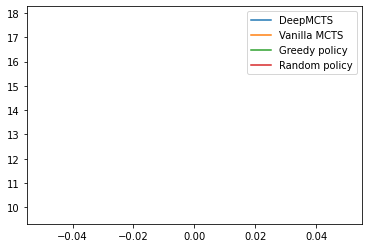


Policy Loss 2.9090710481007895
Value Loss 108.97819900512695

Policy Loss 2.9179643591245017
Value Loss 92.19639492034912
2/50
[15, 13, 10, 0, 1, 12, 5, 17, 14] 15.870868712358227
[0, 1, 5, 15, 13, 4, 19, 11, 3] 12.247118486820401
[11, 15, 10, 16, 5, 1, 19, 3, 4] 9.65483146493601
[9, 14, 13, 15, 1, 2, 10, 16, 17] 13.975728204052691
[15, 1, 11, 5, 9, 12, 0, 3, 10] 10.96518218303195
[10, 15, 0, 9, 2, 4, 3, 16, 11] 11.801825349020415
[15, 10, 1, 5, 14, 3, 12, 16, 7] 13.180096735772285
[0, 16, 13, 11, 10, 4, 1, 18, 19] 10.915104259332546
[4, 9, 2, 11, 1, 0, 12, 18, 10] 9.965610478758485
[9, 15, 13, 16, 4, 1, 12, 17, 14] 7.559312907587077
[0, 1, 2, 3, 4, 5, 6, 7, 8] 9.975086032981286












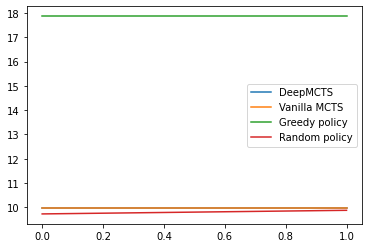


Policy Loss 2.862884839375814
Value Loss 45.96288871765137

Policy Loss 2.9281468391418457
Value Loss 35.96878989537557
3/50
[10, 2, 16, 4, 13, 11, 5, 14, 9] 13.152830820249525
[4, 16, 14, 11, 1, 19, 18, 9, 17] 9.193700070008852
[4, 14, 13, 5, 16, 0, 10, 12, 7] 13.987288161288008
[14, 9, 2, 16, 12, 3, 19, 10, 4] 10.840020874462983
[1, 11, 4, 0, 14, 10, 9, 12, 19] 10.221602091170361
[2, 13, 5, 4, 11, 16, 3, 14, 19] 9.77913789333249
[9, 16, 10, 4, 1, 5, 19, 17, 18] 12.773067502110036
[1, 5, 4, 14, 13, 12, 9, 2, 7] 7.806114633094702
[1, 14, 13, 11, 5, 9, 16, 17, 19] 8.812040294393407
[0, 2, 10, 5, 4, 19, 11, 1, 9] 11.766925701410042
[0, 1, 2, 3, 4, 5, 6, 7, 8] 9.975086032981286












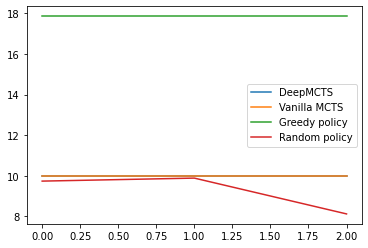


Policy Loss 2.8940027157465615
Value Loss 23.30702606836955

Policy Loss 2.885989010334015
Value Loss 17.771771907806396
4/50
[2, 15, 3, 11, 4, 1, 0, 9, 14] 10.020390952087487
[16, 5, 13, 15, 14, 1, 0, 17, 10] 11.072991077778003
[10, 9, 13, 14, 16, 3, 1, 18, 12] 10.037079211640236
[2, 10, 0, 5, 15, 19, 14, 18, 13] 11.111482436453164
[16, 10, 15, 4, 13, 9, 18, 5, 19] 8.643102516246913
[16, 9, 11, 14, 12, 3, 1, 15, 13] 8.74064248470568
[13, 16, 2, 14, 0, 19, 5, 11, 12] 9.279693483235112
[1, 5, 2, 11, 14, 3, 10, 19, 16] 11.298943812091819
[1, 9, 0, 16, 4, 15, 14, 11, 19] 10.243072904053857
[9, 13, 3, 16, 0, 1, 19, 4, 11] 9.499795389504955
[0, 1, 2, 3, 4, 5, 6, 7, 8] 9.975086032981286












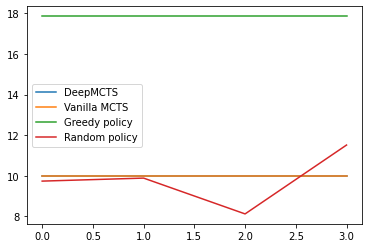


Policy Loss 2.9018452962239585
Value Loss 7.395099401473999

Policy Loss 2.8863601684570312
Value Loss 5.338188608487447
5/50
[2, 5, 9, 13, 11, 15, 10, 1, 19] 11.092723546315417
[2, 5, 9, 3, 13, 16, 10, 4, 14] 12.058460577296772
[15, 2, 3, 5, 13, 9, 16, 18, 7] 8.048538875518943
[5, 0, 9, 10, 13, 16, 3, 17, 19] 14.207322332107028
[3, 13, 1, 15, 5, 4, 18, 0, 2] 10.182940968547328
[3, 13, 10, 12, 5, 9, 0, 19, 11] 13.960522591712913
[13, 1, 5, 0, 14, 12, 19, 4, 2] 10.374951088219388
[5, 9, 0, 12, 3, 13, 11, 10, 16] 10.024953662646837
[13, 9, 1, 4, 15, 0, 5, 11, 17] 9.807643099317112
[5, 9, 12, 11, 1, 3, 14, 0, 16] 8.56729360173571
[0, 1, 2, 3, 4, 5, 6, 7, 9] 9.968682486056174












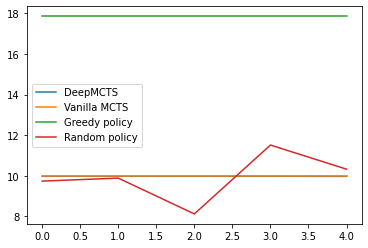


Policy Loss 2.8794004122416177
Value Loss 5.418954014778137

Policy Loss 2.8495071132977805
Value Loss 6.097827653090159
6/50
[2, 0, 11, 12, 15, 14, 16, 13, 19] 9.786864304237993
[4, 12, 14, 3, 0, 10, 19, 2, 1] 13.597340010695618
[16, 1, 10, 14, 15, 9, 2, 12, 0] 9.768890482158781
[11, 2, 9, 12, 13, 4, 19, 15, 17] 12.169456446395603
[2, 0, 3, 4, 10, 9, 12, 14, 19] 17.822306920651762
[11, 3, 16, 2, 4, 10, 1, 17, 9] 13.829418125780208
[16, 15, 12, 2, 0, 4, 9, 1, 17] 9.276036588207766
[0, 1, 15, 4, 2, 13, 9, 10, 11] 10.325957901835405
[3, 14, 16, 10, 2, 13, 5, 1, 9] 10.109376919481463
[0, 10, 2, 13, 1, 16, 9, 12, 15] 9.031314610503967
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












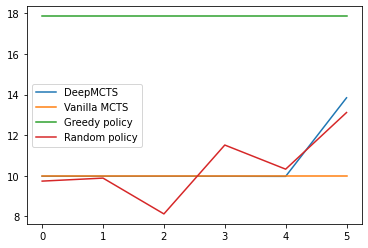


Policy Loss 2.875852624575297
Value Loss 6.4518513679504395

Policy Loss 2.8484281301498413
Value Loss 7.559489528338115
7/50
[15, 3, 14, 16, 1, 10, 11, 2, 5] 9.961761365423287
[9, 18, 1, 15, 0, 10, 12, 11, 19] 9.267866509770657
[14, 16, 15, 1, 13, 18, 4, 10, 7] 10.925247006502998
[9, 18, 13, 16, 1, 2, 15, 10, 7] 8.75634434067321
[4, 0, 9, 18, 2, 3, 16, 11, 15] 8.987932814912885
[15, 12, 11, 18, 0, 16, 5, 9, 10] 9.30810603764317
[15, 0, 18, 4, 1, 11, 10, 14, 2] 10.747056750703964
[15, 12, 3, 14, 13, 0, 9, 2, 10] 17.486344439463984
[9, 14, 15, 13, 4, 0, 18, 2, 1] 8.585238454806724
[15, 4, 13, 3, 1, 5, 9, 16, 17] 10.835651526227158
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












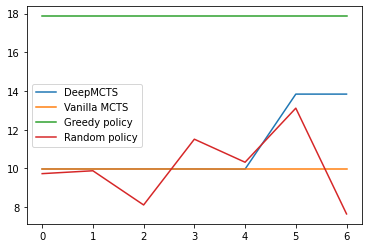


Policy Loss 2.830769697825114
Value Loss 6.113470474878947

Policy Loss 2.823075234889984
Value Loss 7.555832544962565
8/50
[1, 11, 10, 18, 3, 15, 12, 19, 5] 9.010038217805528
[13, 12, 11, 0, 5, 18, 16, 9, 10] 9.82700463470203
[12, 13, 1, 4, 2, 11, 17, 16, 10] 11.901663422996547
[12, 11, 16, 9, 3, 4, 0, 5, 13] 9.467915211978408
[14, 9, 0, 4, 1, 3, 12, 17, 5] 11.404020210812902
[13, 14, 1, 18, 5, 11, 0, 9, 2] 8.523093856086371
[13, 12, 11, 0, 4, 3, 5, 18, 15] 8.102223815492119
[16, 12, 10, 0, 5, 4, 2, 3, 13] 11.997184766752408
[16, 11, 13, 4, 10, 18, 14, 5, 2] 11.566756348970614
[13, 14, 18, 16, 5, 4, 11, 3, 7] 7.897023724003792
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












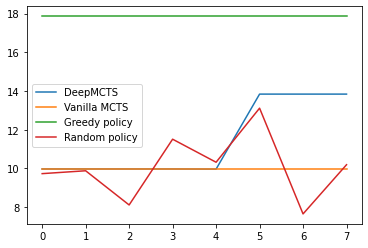


Policy Loss 2.8775277932484946
Value Loss 2.471931795279185

Policy Loss 2.8450001080830893
Value Loss 2.126847634712855
9/50
[4, 14, 0, 1, 3, 15, 17, 10, 9] 13.405568389028225
[9, 12, 1, 11, 2, 19, 4, 0, 13] 8.351569178549248
[16, 10, 9, 14, 3, 12, 18, 15, 1] 9.789483188475625
[12, 1, 0, 16, 14, 4, 3, 13, 2] 11.890991476623181
[12, 18, 0, 10, 13, 1, 19, 17, 9] 14.015874838082302
[14, 10, 0, 9, 12, 3, 18, 1, 2] 10.424776118816954
[1, 12, 18, 13, 9, 11, 4, 14, 7] 6.987932814912884
[18, 0, 1, 9, 11, 13, 3, 16, 15] 8.44708773589818
[3, 1, 11, 10, 16, 13, 4, 18, 14] 9.76126001835604
[3, 10, 12, 9, 15, 18, 19, 11, 7] 12.019893354468163
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












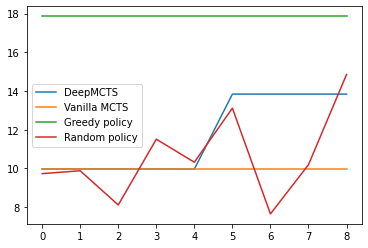


Policy Loss 2.824792981147766
Value Loss 5.3664456605911255

Policy Loss 2.8179661631584167
Value Loss 4.945682883262634
10/50
[2, 12, 0, 14, 18, 16, 10, 17, 5] 13.277336814906857
[4, 3, 0, 9, 13, 16, 18, 11, 1] 9.14339715378488
[16, 12, 18, 1, 10, 5, 4, 11, 14] 9.709083568516824
[0, 3, 13, 4, 15, 10, 9, 11, 17] 15.68689915476163
[11, 12, 3, 14, 16, 13, 1, 17, 7] 10.936585375267875
[3, 9, 4, 2, 11, 10, 17, 18, 13] 13.564992666615833
[12, 14, 11, 9, 1, 18, 17, 16, 5] 6.442478269458337
[16, 13, 3, 14, 9, 10, 12, 5, 2] 10.950940647333422
[18, 3, 1, 2, 13, 0, 10, 15, 9] 14.578228183899078
[14, 0, 3, 10, 12, 2, 9, 13, 16] 9.9835553318295
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












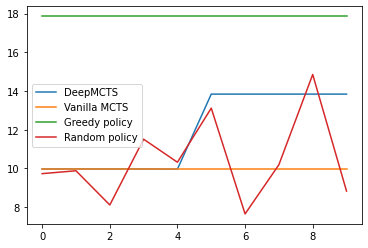


Policy Loss 2.818778077761332
Value Loss 6.063283284505208

Policy Loss 2.8027486006418862
Value Loss 6.223488748073578
11/50
[16, 4, 3, 12, 9, 1, 11, 15, 7] 7.351569178549247
[16, 9, 4, 0, 2, 19, 17, 11, 15] 11.906813548732403
[2, 11, 12, 1, 15, 14, 13, 10, 16] 10.764899637568313
[12, 18, 0, 4, 9, 11, 2, 17, 13] 10.162810164105263
[9, 16, 12, 18, 2, 0, 10, 3, 4] 10.977383768260847
[1, 9, 0, 16, 14, 11, 3, 15, 17] 10.369078745061838
[4, 1, 16, 13, 0, 2, 3, 5, 18] 8.442478269458338
[0, 1, 2, 13, 4, 11, 16, 3, 10] 12.245063453970474
[16, 1, 3, 11, 13, 4, 2, 12, 7] 7.914479972375228
[0, 9, 11, 3, 4, 15, 14, 10, 7] 11.25141651677381
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












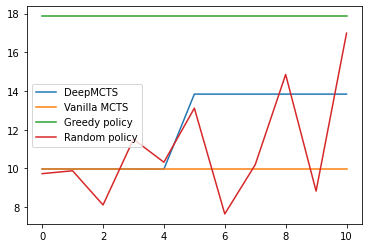


Policy Loss 2.8048352797826133
Value Loss 2.561382293701172

Policy Loss 2.794482151667277
Value Loss 2.754875143369039
12/50
[2, 18, 12, 1, 9, 14, 16, 13, 4] 7.726258243631933
[2, 3, 1, 0, 15, 5, 9, 19, 18] 9.944383675959918
[14, 3, 1, 2, 13, 11, 16, 4, 15] 9.208034721182727
[1, 16, 9, 11, 0, 10, 4, 5, 13] 11.619106505095793
[12, 9, 4, 14, 11, 2, 3, 1, 19] 9.266585748938862
[11, 16, 14, 1, 15, 4, 19, 9, 17] 9.779414813856922
[18, 3, 2, 9, 14, 10, 16, 5, 13] 9.584749850107144
[14, 0, 11, 18, 2, 10, 12, 17, 5] 13.724602679423779
[0, 9, 2, 3, 18, 12, 16, 19, 17] 11.916157193620393
[0, 11, 9, 16, 13, 14, 19, 18, 12] 9.086822599970606
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












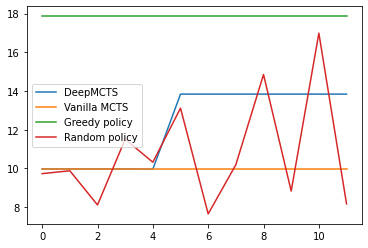


Policy Loss 2.781621058781942
Value Loss 3.1575496991475425

Policy Loss 2.7858039339383445
Value Loss 2.880239794651667
13/50
[3, 0, 1, 12, 11, 18, 15, 2, 13] 8.292626263213595
[1, 2, 3, 14, 4, 5, 17, 15, 9] 11.443798795338736
[2, 3, 4, 12, 0, 9, 15, 10, 17] 16.243790179889952
[2, 0, 9, 3, 15, 1, 12, 10, 17] 16.329727472976277
[2, 12, 14, 4, 10, 5, 16, 0, 3] 11.352458051801523
[11, 0, 16, 13, 9, 1, 17, 15, 3] 9.75556581460078
[13, 16, 4, 14, 9, 2, 15, 5, 1] 8.346422426408719
[2, 16, 1, 12, 4, 9, 18, 17, 10] 8.844756027031082
[12, 11, 3, 13, 1, 0, 15, 9, 14] 10.442486650431517
[16, 11, 0, 4, 10, 3, 17, 18, 13] 13.27697834551121
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












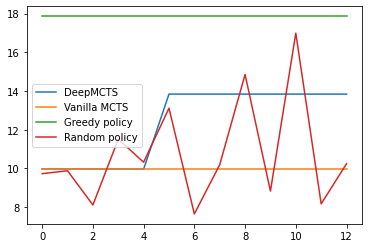


Policy Loss 2.7994710206985474
Value Loss 7.284907897313436

Policy Loss 2.7714046835899353
Value Loss 7.11919363339742
14/50
[11, 4, 2, 15, 12, 5, 14, 17, 19] 9.749640153302073
[9, 2, 16, 1, 15, 13, 3, 4, 11] 8.934001972669762
[0, 4, 1, 12, 18, 2, 16, 10, 9] 8.498218242281435
[1, 12, 0, 11, 2, 9, 16, 15, 14] 7.459934517829774
[16, 11, 3, 1, 14, 5, 12, 15, 9] 8.520708863632073
[3, 9, 2, 0, 12, 13, 5, 14, 4] 10.337585206028198
[11, 9, 18, 4, 2, 16, 0, 13, 10] 13.788412482453317
[13, 18, 3, 14, 12, 9, 15, 10, 7] 12.443849419351446
[3, 14, 18, 4, 10, 1, 9, 2, 5] 11.423097005386765
[16, 14, 9, 3, 12, 13, 10, 0, 17] 16.161474952336043
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












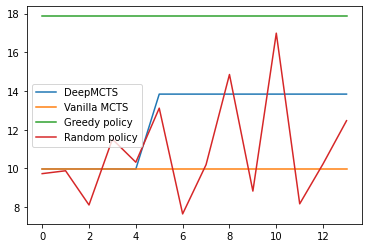


Policy Loss 2.804693897565206
Value Loss 5.462880531946818

Policy Loss 2.779984255631765
Value Loss 6.145625909169515
15/50
[11, 4, 2, 18, 10, 12, 15, 5, 13] 9.115820154487945
[14, 11, 3, 18, 2, 4, 12, 19, 5] 9.844398357546364
[2, 3, 12, 16, 15, 14, 13, 9, 0] 11.541612973499749
[4, 3, 13, 2, 18, 12, 11, 19, 1] 8.673632877174505
[16, 9, 1, 13, 11, 4, 15, 2, 0] 8.38985290300091
[4, 0, 3, 16, 13, 9, 14, 17, 7] 13.360218978669025
[11, 0, 3, 14, 12, 16, 15, 9, 4] 9.046562401577084
[3, 0, 16, 12, 2, 18, 15, 11, 4] 8.702358760254015
[2, 11, 12, 0, 9, 15, 3, 19, 1] 11.19826458368887
[1, 9, 18, 4, 14, 16, 15, 0, 10] 8.995913509061515
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












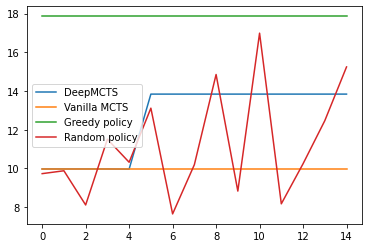


Policy Loss 2.7544371287027993
Value Loss 2.592150608698527

Policy Loss 2.7581673661867776
Value Loss 2.23954846461614
16/50
[1, 2, 13, 11, 14, 3, 19, 10, 0] 13.552924410756669
[3, 4, 18, 13, 0, 2, 1, 14, 17] 12.499400715518508
[9, 4, 11, 2, 14, 13, 16, 0, 15] 10.545317241872908
[9, 4, 0, 11, 15, 18, 14, 2, 10] 13.982753398458469
[2, 14, 11, 15, 9, 1, 4, 16, 19] 10.220832822113215
[14, 3, 11, 12, 9, 5, 1, 16, 19] 7.533387360367429
[0, 11, 12, 4, 14, 18, 9, 2, 1] 8.076865431880114
[2, 3, 16, 1, 10, 13, 9, 14, 7] 12.446193247738353
[12, 14, 0, 4, 3, 11, 10, 2, 1] 12.483369745641069
[12, 16, 3, 9, 1, 0, 13, 19, 17] 10.302040168522467
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












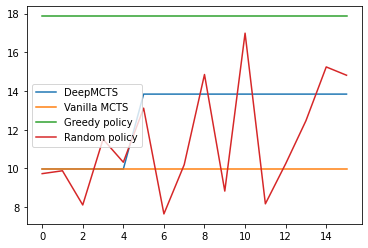


Policy Loss 2.743465701738993
Value Loss 6.123999357223511

Policy Loss 2.742993116378784
Value Loss 5.041768729686737
17/50
[3, 16, 9, 1, 12, 15, 18, 19, 10] 8.938429045653015
[11, 0, 3, 2, 4, 14, 1, 16, 19] 10.851073575909302
[9, 13, 11, 16, 1, 3, 5, 2, 17] 10.786564157319393
[9, 3, 0, 18, 11, 4, 15, 5, 14] 8.959292929880261
[11, 3, 16, 13, 15, 10, 19, 14, 9] 13.046840712242808
[0, 1, 2, 3, 10, 15, 4, 14, 18] 12.37132316220024
[13, 12, 18, 2, 16, 5, 19, 10, 0] 9.97447054301849
[12, 0, 16, 2, 3, 15, 5, 14, 9] 9.230589040693584
[13, 16, 3, 14, 12, 4, 0, 10, 15] 11.744326444731213
[9, 0, 11, 15, 3, 16, 19, 12, 17] 9.971883090468733
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












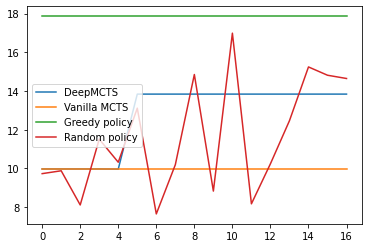


Policy Loss 2.7922951777776084
Value Loss 1.7305622895558674

Policy Loss 2.77876607577006
Value Loss 1.5792049119869869
18/50
[4, 1, 2, 11, 13, 3, 10, 15, 5] 9.79975368523757
[0, 4, 16, 15, 3, 1, 9, 13, 5] 9.010038217805528
[14, 16, 12, 11, 2, 10, 5, 13, 15] 8.922949271223441
[2, 13, 9, 18, 10, 0, 4, 12, 15] 11.325092349748184
[0, 2, 11, 14, 18, 12, 13, 15, 1] 9.141074703551425
[9, 18, 2, 11, 1, 13, 17, 19, 10] 10.394176702122198
[2, 0, 9, 3, 1, 16, 15, 13, 10] 11.245012969848698
[13, 4, 2, 14, 15, 0, 3, 12, 10] 12.765016093183124
[2, 4, 16, 3, 13, 14, 10, 11, 9] 11.329561112900658
[12, 4, 14, 18, 2, 9, 3, 1, 7] 9.93325241560553
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












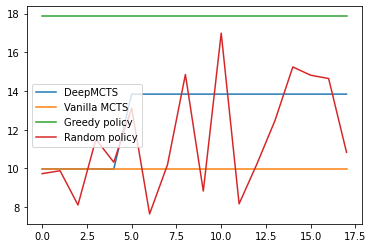


Policy Loss 2.7549045085906982
Value Loss 1.3151359260082245

Policy Loss 2.75778591632843
Value Loss 1.1807125185926755
19/50
[0, 1, 4, 13, 2, 14, 5, 17, 16] 11.608257445905544
[9, 12, 11, 13, 16, 0, 4, 7, 19] 8.695955213328903
[13, 14, 4, 0, 3, 9, 5, 1, 19] 10.367048952978822
[16, 11, 12, 4, 15, 3, 10, 18, 7] 11.333570641516136
[9, 1, 18, 16, 0, 11, 10, 5, 2] 7.442478269458339
[13, 12, 1, 2, 15, 16, 9, 17, 0] 9.108607650424318
[1, 9, 2, 4, 15, 16, 11, 0, 13] 8.377494725768896
[3, 13, 0, 11, 14, 9, 19, 7, 17] 12.369372345046633
[16, 12, 4, 2, 18, 14, 13, 3, 0] 9.729111897632949
[9, 3, 14, 0, 18, 2, 16, 17, 11] 11.626415598308009
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












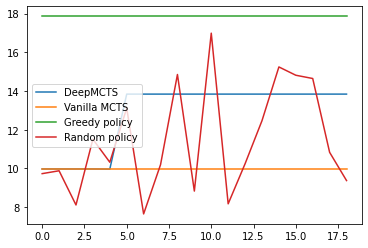


Policy Loss 2.7633567253748574
Value Loss 2.5144222180048623

Policy Loss 2.7569369276364646
Value Loss 2.129635989665985
20/50
[0, 1, 3, 12, 9, 2, 10, 16, 18] 9.390573491056948
[16, 11, 4, 14, 10, 0, 12, 15, 1] 10.27373885292821
[2, 1, 11, 14, 10, 13, 12, 19, 6] 15.489524071465713
[4, 9, 16, 14, 2, 10, 5, 0, 18] 9.38985290300091
[16, 11, 12, 4, 0, 2, 13, 15, 18] 7.351569178549248
[4, 9, 13, 3, 12, 10, 16, 1, 0] 10.967133942019911
[11, 13, 4, 9, 15, 0, 19, 14, 12] 11.943502735373887
[14, 11, 4, 2, 3, 0, 9, 19, 5] 10.230357057337125
[4, 12, 18, 9, 0, 13, 15, 11, 1] 7.8235708814661375
[11, 16, 13, 0, 2, 18, 10, 12, 5] 8.890334586727363
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












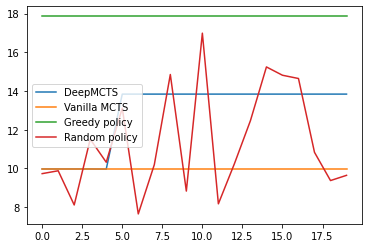


Policy Loss 2.7646824518839517
Value Loss 2.771670321623484

Policy Loss 2.7547909021377563
Value Loss 3.116278429826101
21/50
[2, 14, 11, 4, 5, 9, 19, 13, 3] 9.230357057337127
[11, 0, 12, 16, 2, 10, 5, 1, 14] 11.310856417782222
[0, 1, 13, 4, 14, 18, 16, 9, 6] 9.787662925389085
[12, 11, 15, 2, 4, 9, 14, 13, 6] 12.216135019526492
[11, 3, 18, 16, 15, 5, 2, 1, 7] 7.089894607268297
[14, 18, 9, 1, 13, 2, 19, 10, 12] 10.10399318102349
[16, 3, 0, 15, 4, 18, 14, 1, 2] 11.621711156493388
[11, 1, 9, 12, 4, 18, 5, 13, 14] 8.745073285930216
[12, 9, 18, 1, 10, 13, 19, 17, 14] 13.081849144263458
[9, 18, 14, 16, 4, 0, 1, 13, 6] 8.987932814912883
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












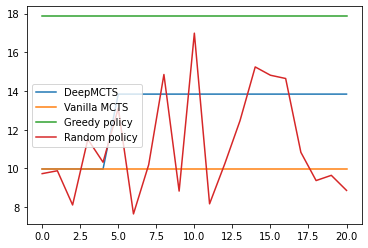


Policy Loss 2.743386745452881
Value Loss 3.8303146759668985

Policy Loss 2.7487804889678955
Value Loss 3.288000136613846
22/50
[12, 11, 16, 1, 0, 13, 15, 17, 5] 7.1956765439507135
[2, 11, 0, 9, 18, 16, 1, 3, 19] 8.369025426920683
[13, 14, 11, 4, 2, 0, 1, 18, 12] 8.321266148246217
[11, 13, 3, 14, 10, 12, 15, 16, 0] 12.409746202839946
[11, 9, 3, 16, 4, 10, 18, 12, 19] 10.812101577486398
[3, 13, 14, 18, 10, 15, 4, 12, 6] 12.033866629026653
[12, 18, 14, 0, 16, 10, 11, 19, 2] 10.590704480414047
[0, 14, 11, 12, 3, 16, 9, 18, 13] 9.109144936125006
[1, 14, 2, 15, 12, 5, 4, 17, 3] 10.622502370791247
[3, 14, 0, 16, 18, 13, 2, 1, 5] 9.921982780897455
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












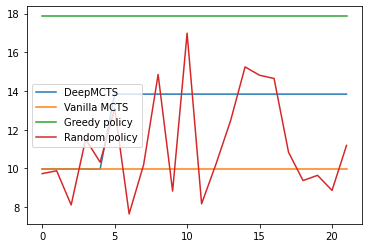


Policy Loss 2.720428705215454
Value Loss 1.7921997606754303

Policy Loss 2.741516729195913
Value Loss 1.9403455505768459
23/50
[18, 2, 11, 15, 1, 9, 14, 5, 0] 9.197782060922416
[0, 16, 14, 18, 3, 12, 13, 19, 9] 8.593993420973488
[16, 2, 0, 12, 10, 18, 11, 5, 15] 9.654382548317798
[9, 0, 12, 15, 11, 3, 16, 7, 13] 9.122223701413057
[9, 2, 16, 14, 1, 10, 15, 18, 5] 8.117125630273637
[18, 3, 14, 11, 13, 16, 4, 5, 12] 8.59201694703163
[0, 11, 3, 13, 1, 10, 2, 7, 16] 13.06092573290545
[18, 9, 12, 11, 15, 16, 4, 1, 10] 11.067543302105703
[11, 1, 3, 12, 10, 15, 13, 7, 18] 10.337096601328618
[9, 2, 1, 16, 10, 0, 11, 13, 5] 10.056302636405823
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












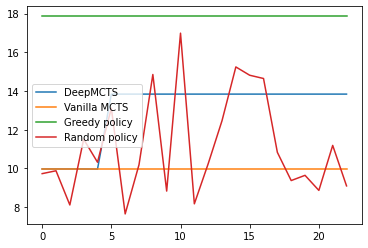


Policy Loss 2.7547487020492554
Value Loss 2.206892410914103

Policy Loss 2.755531986554464
Value Loss 1.9245328952868779
24/50
[1, 0, 16, 2, 14, 18, 11, 15, 13] 9.143397153784882
[16, 14, 18, 2, 13, 11, 19, 3, 4] 11.55220382270063
[11, 12, 4, 14, 0, 15, 9, 3, 2] 10.418100900454014
[2, 1, 9, 4, 3, 16, 0, 19, 7] 9.844398357546364
[0, 9, 1, 18, 2, 14, 4, 19, 12] 9.995913509061516
[4, 1, 9, 12, 18, 2, 3, 0, 15] 8.619918968193137
[3, 0, 14, 2, 1, 11, 5, 7, 12] 10.138673694409903
[4, 14, 12, 11, 16, 18, 19, 3, 17] 10.701959433535674
[1, 3, 14, 16, 2, 15, 5, 13, 11] 9.635398742622712
[0, 4, 3, 12, 1, 5, 10, 13, 17] 15.7294407400329
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












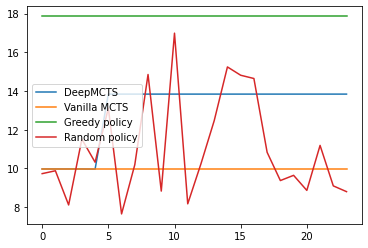


Policy Loss 2.700304547945658
Value Loss 3.8066200812657676

Policy Loss 2.70353231827418
Value Loss 3.5197657148043313
25/50
[0, 14, 16, 2, 9, 4, 18, 17, 10] 11.318063205733663
[9, 12, 4, 0, 16, 1, 11, 15, 10] 9.361213017968288
[4, 12, 0, 2, 3, 16, 15, 1, 5] 10.605367383757509
[11, 9, 3, 12, 10, 18, 19, 5, 4] 9.617935503419387
[12, 11, 1, 18, 16, 3, 4, 5, 13] 7.92553267382155
[2, 4, 18, 16, 14, 10, 1, 17, 3] 13.470762816981889
[3, 11, 9, 16, 2, 5, 12, 19, 17] 11.282095401275393
[13, 0, 18, 16, 10, 15, 9, 11, 12] 9.066227107246837
[13, 0, 2, 16, 1, 18, 4, 10, 15] 11.181177585615647
[16, 12, 0, 18, 14, 4, 10, 19, 13] 10.938379455753145
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












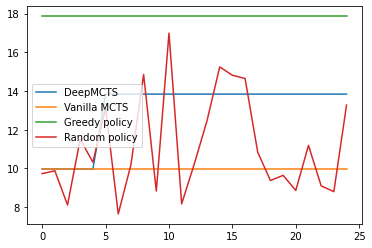


Policy Loss 2.7369781732559204
Value Loss 2.1502252320448556

Policy Loss 2.7300485372543335
Value Loss 2.1765300383170447
26/50
[0, 13, 16, 18, 12, 3, 5, 2, 10] 11.676695428943741
[2, 12, 9, 1, 16, 15, 3, 0, 4] 10.95746244124797
[12, 2, 14, 16, 0, 5, 1, 9, 19] 9.718039484193714
[2, 14, 3, 15, 1, 5, 10, 7, 9] 10.001011580200938
[14, 0, 18, 12, 16, 4, 3, 9, 13] 9.403420272988543
[13, 9, 4, 0, 15, 10, 1, 7, 12] 10.077319496774528
[3, 4, 0, 11, 1, 12, 2, 17, 6] 12.696791184461368
[2, 9, 16, 14, 12, 3, 13, 1, 0] 11.661221015980395
[4, 9, 3, 15, 14, 10, 19, 2, 0] 13.811049089113522
[9, 2, 11, 4, 10, 5, 19, 17, 1] 14.19153067840285
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












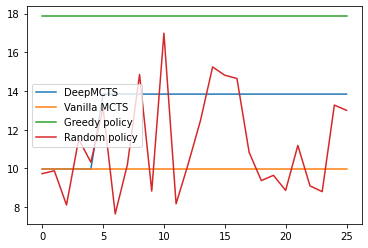


Policy Loss 2.70466681321462
Value Loss 2.747414708137512

Policy Loss 2.717373251914978
Value Loss 2.6560457249482474
27/50
[13, 2, 0, 16, 18, 11, 12, 19, 6] 9.07821524847907
[14, 0, 9, 16, 10, 4, 19, 11, 17] 15.811099730100578
[11, 2, 12, 9, 4, 16, 3, 0, 18] 8.702358760254015
[3, 11, 4, 14, 15, 1, 2, 0, 13] 11.895857564406143
[13, 3, 0, 18, 15, 12, 19, 4, 6] 10.803709863426304
[3, 12, 18, 0, 11, 4, 1, 19, 5] 9.852818975393468
[2, 14, 3, 15, 16, 18, 5, 11, 6] 8.5030843300644
[2, 12, 11, 15, 16, 13, 10, 5, 18] 8.934001972669762
[13, 2, 14, 0, 9, 12, 10, 3, 19] 14.320412206062286
[0, 12, 14, 2, 3, 11, 9, 19, 18] 9.195676543950713
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












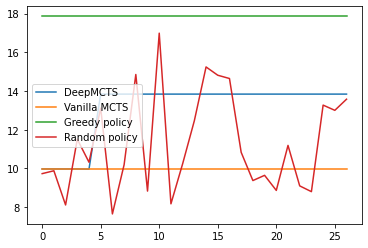


Policy Loss 2.7101457516352334
Value Loss 7.015568971633911

Policy Loss 2.7292670011520386
Value Loss 6.36414357026418
28/50
[9, 2, 14, 4, 12, 15, 13, 7, 1] 8.139447966428035
[16, 4, 11, 1, 0, 12, 19, 15, 2] 10.265358832061235
[0, 3, 9, 2, 14, 18, 11, 1, 6] 9.932593110642483
[0, 4, 2, 1, 11, 15, 9, 3, 17] 10.867955543244634
[16, 4, 9, 13, 14, 11, 0, 19, 15] 8.823570881466138
[3, 16, 11, 18, 1, 5, 13, 17, 0] 9.165954061189492
[16, 3, 0, 9, 13, 1, 4, 5, 12] 9.369297098358508
[4, 14, 1, 18, 16, 5, 19, 0, 10] 9.71520554218561
[9, 13, 18, 11, 10, 3, 1, 7, 0] 11.718266464589187
[1, 4, 9, 18, 14, 3, 0, 15, 12] 8.412175239155307
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058












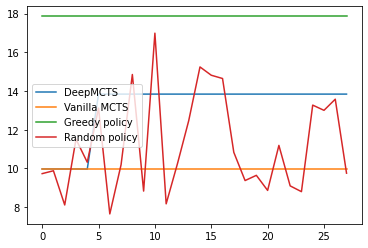


Policy Loss 2.7273083130518594
Value Loss 1.1245631674925487

Policy Loss 2.727345565954844
Value Loss 1.1471432795127232
29/50
[2, 4, 1, 11, 10, 15, 13, 7, 3] 12.054725489182303
[2, 16, 9, 4, 3, 1, 18, 0, 7] 8.741131089405258
[13, 14, 12, 16, 4, 9, 0, 10, 5] 10.250002405659924
[11, 12, 18, 3, 0, 5, 10, 14, 13] 11.080651036401953
[16, 13, 1, 3, 0, 5, 9, 7, 10] 14.312930916499441
[2, 16, 9, 11, 1, 13, 19, 7, 12] 8.796590397870789
[16, 0, 13, 1, 18, 9, 12, 5, 2] 7.756815557178092
[14, 13, 18, 4, 2, 9, 12, 11, 10] 11.241350713355125
[11, 16, 4, 13, 3, 0, 12, 5, 6] 9.525189732957042
[1, 11, 16, 13, 10, 9, 18, 12, 3] 11.89453624466528
[0, 1, 2, 3, 4, 5, 6, 7, 9] 13.841205334196058



KeyboardInterrupt: 

In [48]:
import torch
import math
import pandas as pd
import numpy as np
import random as rand
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

import scipy.spatial.distance as distlib
playlist_length = 10
action_space_size = 1000
model = MDP('MSD.csv', playlist_length, action_space_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = {
    'batch_size': 16,
    'numIters': 50,                                # Total number of training iterations
    'num_simulations': 50,                         # Total number of MCTS simulations to run when deciding on a move to play
    'numEps': 10,                                  # Number of full games (episodes) to run during each iteration
    'numItersForTrainExamplesHistory': 20,
    'epochs': 2,                                    # Number of epochs of training per iteration
    'checkpoint_path': 'latest.pth'                 # location to save latest set of weights
}

dl_model = Connect2Model(model.n_features*model.playlist_length*10, model.n_songs, device)
# print(model.n_songs)
trainer = Trainer(dl_model, model, args)



# Random
random_scores = [get_random_trajectory(model) for i in range(100)]
avg_random_score = sum(random_scores)/len(random_scores)

greedy_score = get_greedy_trajectory(model)

trainer.learn(1, avg_random_score, greedy_score)
data = {"MCTS": trainer.scores_mcts,
        "MCTS_DL": trainer.scores_mcts_dl,
        "GREEDY": trainer.scores_greedy,
        "RANDOM": trainer.scores_random}

# with open(filepath+'{}_{}_{}_{}.pickle'.format(datetime.now().strftime("%y%m%d%H%M%S"), args['numIters'], args['num_simulations'], args['numEps']), 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open(filepath+'{}_{}_{}_{}.pickle'.format(datetime.now().strftime("%y%m%d%H%M%S"), args['numIters'], args['num_simulations'], args['numEps']), 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

array([11.03824537, 11.03824537, 11.03824537, 11.03824537, 11.03824537,
       11.03824537, 11.03824537, 11.03824537, 11.03824537, 11.03824537,
       11.03824537, 11.03824537, 11.03824537, 11.03824537, 11.03824537,
       11.03824537, 11.03824537, 11.03824537, 11.03824537, 11.03824537,
       11.03824537, 11.03824537, 11.03824537, 11.03824537, 11.03824537,
       11.03824537, 11.03824537, 11.03824537, 11.03824537, 11.03824537,
       11.03824537, 11.03824537, 11.03824537, 11.03824537, 11.03824537,
       11.03824537, 11.03824537, 11.03824537, 11.03824537, 11.03824537,
       11.03824537, 11.03824537, 11.03824537, 11.03824537, 11.03824537,
       11.03824537, 11.03824537, 11.03824537, 11.03824537, 11.03824537])

In [ ]:
print(model.init_prefs)

print(model.filtered_df)

print(model.MC_value(root))


     0    1    2    3    4    5    6   ...   73   74   75   76   77   78   79
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0
12  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0
6   0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0
11  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0
9   1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0

[5 rows x 80 columns]
     duration  key_confidence  ...  artist_hotttnesss  song_hotttnesss
0   252.05506           0.777  ...           0.394032         0.542899
1   156.55138           0.808  ...           0.356992         0.299877
2   318.45832           0.764  ...           0.406985         0.463490
3   273.18812           0.226  ...           0.373679         0.449940
4   262.26893           0.038  ...           0.410229         0.212045
5   216.47628           0.564  ...           0.446733         0.270776
6   217.5734

TypeError: ignored

In [ ]:
print(model.phi_s)
print(model.theta_s(0))

print(np.dot(model.phi_s, model.theta_s(5)))



[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
